<a href="https://colab.research.google.com/github/Nick7900/permutation_test/blob/main/b_within_session_between_trial_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Perform permutation - Within-session, between-trial tests**

This tutorial demonstrates the usage of the ```within_session_between_trial_test``` function for performing permutation testing in the context of within-session and between-trial analysis.

The function is designed for scenarios where subjects undergo testing in different trials, and they are presented with a stimulus for a period of time across one or multiple sessions. It is particularly relevant when multiple trials exist within each session, and the goal is to assess the significance of the observed relationship between independent and dependent variables across these trials.

Like other permutation tests, it is essential to consider and address potential confounding variables that could influence the results. Confounding variables are external factors that are associated with both the independent variable and the dependent variable.

The ```within_session_between_trial_test``` makes it possible to mitigate the influence of confounding variables by regressing them out from data before performing the between-subject test.


The function ```within_session_between_trial_test``` can be useful:

* **Neuroscience Research**: In neuroscience studies, researchers often collect continuous brain signals, such as electroencephalography (EEG), Magnetoencephalography (MEG) or functional magnetic resonance imaging (fMRI) data, during different trials where they have been presented of a stimulus for a period of time in one or multiple sessions. By using ```within_session_between_trial_test```, you can assess the significance of the relationship between the brain signals and a specific variable (e.g., task performance, stimulus properties) within each session.


## **Permutation testing**
Permutation testing is a resampling technique that involves random permutation of the observed data and comparing it to the observed effect to by generating a null distribution under the null hypothesis.

The null hypothesis states that there is no difference or association between variables of interest.

Under the null model, we can determine the p-value and assess the significance of the effect.

Permutation testing (non-parametric) is particularly useful when the underlying data distribution is unknown or violates certain assumptions required by parametric tests. It provides a flexible and robust alternative for hypothesis testing, especially in cases where parametric assumptions cannot be met.

**We will go though the following steps in this Notebook:**

1. Setup Google Colab
2. Downloading Data for Analysis
3. Data Preparation
4. Within-Session Between-Trial Permutation Testing
5. Example of usage - Regression
6. Visualize results


## **1: Setup Google Colab**
This script was written using **Google Colab** and you need to install different packages to run this code and import libraries to load the data that we prepared in the Notebook ```1_preprocessing_data_selection```.


To use the helper function ```helperfunctions``` you need to install the library **statsmodels**.
```
pip install statsmodels
```
To visualize a process bar while processing the data we need to install the library ```tqdm```
```
pip install tqdm
```

When using **Google Colab** we need to import the following libraries, so we can load the data of interest

```
!pip install requests
!pip install gdown
```

### Install packages

In [ ]:
# Using -q gwpy to hide output in Google Colab
!pip install statsmodels -q gwpy
!pip install tqdm -q gwpy
!pip install requests -q gwpy
!pip install gdown -q gwpy

### Import libraries
Now, we can begin to import the necessary libraries for our analysis. We'll be using ```os``` and ```numpy```, for loading the data and for data manipulation.

In [ ]:
import os
import numpy as np
import requests
import gdown

### Load Helper function
We will use ```helperfunctions.py``` to visualize the different plots of our results

----------------------------
**Note these functions will be remove for loading if they are part of the GLHMM toolbox => no need to run this code**

In [ ]:
# Import helper function
# Get the raw github file
url = 'https://raw.githubusercontent.com/Nick7900/permutation_test/main/helper_functions/helperfunctions.py'
r = requests.get(url)
# Save the function to the directory
with open("helperfunctions.py","w") as f:
  f.write(r.text)

### Load Permutationt testing functions
We will use ```permutation_test.py``` to perform the permutation testing

In [ ]:
# Import helper function
# Get the raw github file
url = 'https://raw.githubusercontent.com/Nick7900/permutation_test/main/helper_functions/permutation_test.py'
r = requests.get(url)
# Save the function to the directory
with open("permutation_test.py","w") as f:
  f.write(r.text)

## **2: Downloading Data for Analysis**
First, we need to load data files into our Python environment.
We will be working with two data files **X_memory.npy**, **y_memory.npy** and **data_idx_memory.npy**.

For this example we are analyzing memory task data measured inside a Magnetoencephalography (MEG) scanner at different sessions and over multiple trials for 1 subject.

In [ ]:
# Downlod files from google colab
# Load X_data (X_memory)
url = "https://drive.google.com/uc?id=1XhjINejfg7yPsxJ_sLjOZQ-1VNOT9ySB&export=download"
gdown.download(url, quiet=True)

# Load dependent variables (y_memory)
url = "https://drive.google.com/uc?id=17QcxDcvZasvsQ-iBTL2uqsDbBgBOTLkj&export=download"
gdown.download(url, quiet=True)

# Load indices
url = "https://drive.google.com/uc?id=12aOoMd6DheYb9PfPfOFi3oytemH7enqI&export=download"
gdown.download(url, quiet=True)

'idx_session.npy'

In [ ]:
# Show shape of the data
current_directory = os.getcwd()
folder_name = ""
file_name = '/X_memory.npy'

# Load X data
file_path = os.path.join(current_directory+folder_name+file_name)
X_data = np.load(file_path)

# Load y data
file_name = '/y_memory.npy'
file_path = os.path.join(current_directory+folder_name+file_name)
y_data = np.load(file_path)


# Load indices
file_name = '/idx_session.npy'
file_path = os.path.join(current_directory+folder_name+file_name)
idx_data = np.load(file_path)


print(f"Data dimension of X Memory data: {X_data.shape}")
print(f"Data dimension of y Memory data: {y_data.shape}")
print(f"Data dimension of indices Memory: {idx_data.shape}")

Data dimension of X Memory data: (250, 6595, 64)
Data dimension of y Memory data: (6595,)
Data dimension of indices Memory: (15, 2)


### Look at the data

Now we can look at the data structure.
- X_data: 3D array of shape (n_timepoints, n_trials, n_features)
- D_data: 2D array of shape (n_trials, n_predictions)
- idx_data: 2D array of shape (n_sessions, 2)

```X_data``` represents the measurements taken from the subject. It is a list with three elements: ```[250, 6595, 64]```. The first element indicates that the subject was measured over a period of ```250``` timestamps. The second element, ```6595```, represents the number of trials conducted. Each trial consists of measuring ```64``` channels inside the MEG scanner.

For each of the ```6595``` trials, we have design-matrix```D_data = [6595,]```. This is an array containing only 0s and 1s. The values in this array indicate whether an image of an animated or inanimate object was shown on a screen during each trial.

Lastly, we have ```idx_data = [15, 2]```. This indicates the number of sessions conducted, which in this case is ```15```. The values in each row represent the start and end indices of the trials.



## **3: Data Preparation**

We need to preprocess our data before we can run permutation testing. This could include dealing with missing numbers, standardizing the data, or doing any required modifications.

In this case,our data has already been preprocessed and is ready for analysis.\
If you need to run any preprocessing processes on your data, you can do so in this section.

## **4: Within-Session Between-Trial Permutation Testing**
Now that we have the data prepared for the analysis we will show how to perform within-session between-trial permutation test using the ```within_session_between_trial_test``` function.

The ```within_session_between_trial_test``` function is specifically designed for conducting permutation tests between trials within a session. In this context, each trial represents the presentation of a stimulus over 250 timestamps.
The function makes use of several helper functions to facilitate permutation generation and statistical calculations. Its primary objective is to assess the statistical significance of observed patterns in the data by generating random permutations and comparing the outcomes.
### **Within-Session Between-Trial Test Illustration**
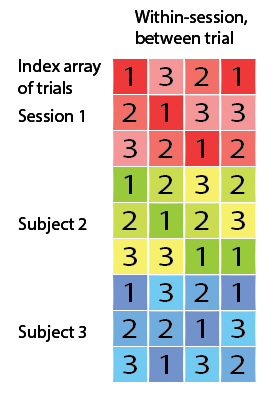

TEXT 1\
**Figure 1**: The sessions are color-coded as red, green, and blue, while numeric labels indicate the sequence of trials (1, 2, and 3) for each session. In the first column, sessions are displayed in their original order with trials, illustrating no permutation (perm=0). Subsequent columns showcase examples of permuted trial indices for each session. Notably, permutations are exclusively conducted between trials of the same session. For instance, in session 1, trials are permuted solely among the trials of session 1, maintaining this pattern across all other trial indices for the respective sessions.

TEXT 2\
**Figure 1**: Sessions are color-coded (red, green, blue) with trial sequence labels (1, 2, 3). The first column: original session order, no permutation (perm=0). Next columns: examples of permuted trial indices per session, exclusively within the same session. E.g., session 1 trials permuted only within session 1, consistent for other session trial indices.

In [ ]:
# import between_subject_test
from permutation_test import within_session_between_trial_test# This function should just be in the GLHMM package

#### **Parameters**
The ```between_subject_test``` function accepts the following parameters:

* X_data (numpy.ndarray):
                                Input data array of shape that can be either a 2D array or a 3D array.
                                For 2D array, it got a shape of (n_ST, n_features), where n_ST represent
                                the number of subjects or trials, and each column represents a feature (e.g., brain
                                region or channel)
                                For a 3D array,it got a shape (n_timepoints, n_ST, n_features), where the first dimension
                                represents timepoints, the second dimension represents the number of subjects or trials,
                                and the third dimension represents features.
                                In the latter case, permutation testing is performed per timepoint for each subject.  
* y_data (numpy.ndarray):
                                The dependent-variable can be either a 2D array or a 3D array.
                                For 2D array, it got a shape of (n_ST, n_predictors), where n_ST represent
                                the number of subjects or trials, and each column of n_predictors represents a
                                dependent variable.
                                For a 3D array,it got a shape (n_timepoints, n_ST, n_predictors), where the first dimension
                                represents timepoints, the second dimension represents the number of subjects or trials,
                                and the third dimension that is n_predictors represents a dependent variable

* idx_data (ndarray):     
                                idx_data (numpy.ndarray): The indices for each trial within the session.
                                It should be a 2D array where each row represents the start and end index for a trial.     
* method (str, optional):       
                                The statistical method to be used for the permutation test. Valid options are
                                "regression", "correlation", or "correlation_com". (default: "regression").
                                "regression" returns the statistical significance of the beta coefficient.
                                "correlation" returns the statistical significance of Pearson’s correlation coefficient.
                                "correlation_com" returns the combined statistical significance of Pearson’s correlation
                                coefficient and 2-tailed p-value

* Nperm (int):  
                                Number of permutations to perform (default: 1000).
* confounds (numpy.ndarray or None, optional):
                                The confounding variables to be regressed out from the input data (X_data).
                                If provided, the regression analysis is performed to remove the confounding effects.
                                (default: None):                               
                                       
* test_statistic_option (bool, optional):
                                If True, the function will return the test statistic for each permutation.
                                (default: False)

### Returns
The ```within_session_between_trial_test``` function returns different things depending on the settings of `test_statistic_option` and `method`, it can return the p-values, correlation coefficients, test statistics.'


* pval (numpy array):
                                p-values for the test (n_timepoints, n_features) if method=="Regression", else
                                (n_timepoints, n_features, n_predictors).
* corr_coef (numpy array):
                                Correlation Coefficients for the test n_timepoints, n_features, n_predictors) if'
                                method=="correlation or "correlation_com", else None.
* test_statistic_list (numpy array):
                                Test statistic values (n_timepoints, Nperm,
                                n_features) if test_statistic_option is True, else None.

* pval_list (numpy array):
                                P-values for each time point (n_timepoints, Nperm, n_features)
                                if test_statistic_option is True and method is "correlation_com", else None.


## **5: Example of usage - Regression**
We will now demonstrate how to use the ```within_session_between_trial_test``` function by performing permutation test for regression coefficients


In [ ]:
# Set the parameters for between-subject testing
method = "regression"
Nperm = 1000
test_statistic_option=True
# Perform between-subject testing
pval, test_statistic_list = within_session_between_trial_test(X_data, y_data, idx_data, method, Nperm, test_statistic_option=test_statistic_option)


performing permutation testing per timepoint


100%|██████████| 250/250 [25:18<00:00,  6.08s/it]


## **6: Visualize results**
 Visualize the results by creating some plotting functions. Here's an example of how to plot the p-values

 **Vizualize p-values using Heatmaps** \
 Using a Heat map, observe the estimated p-values of the beta coefficients from each HMM state.


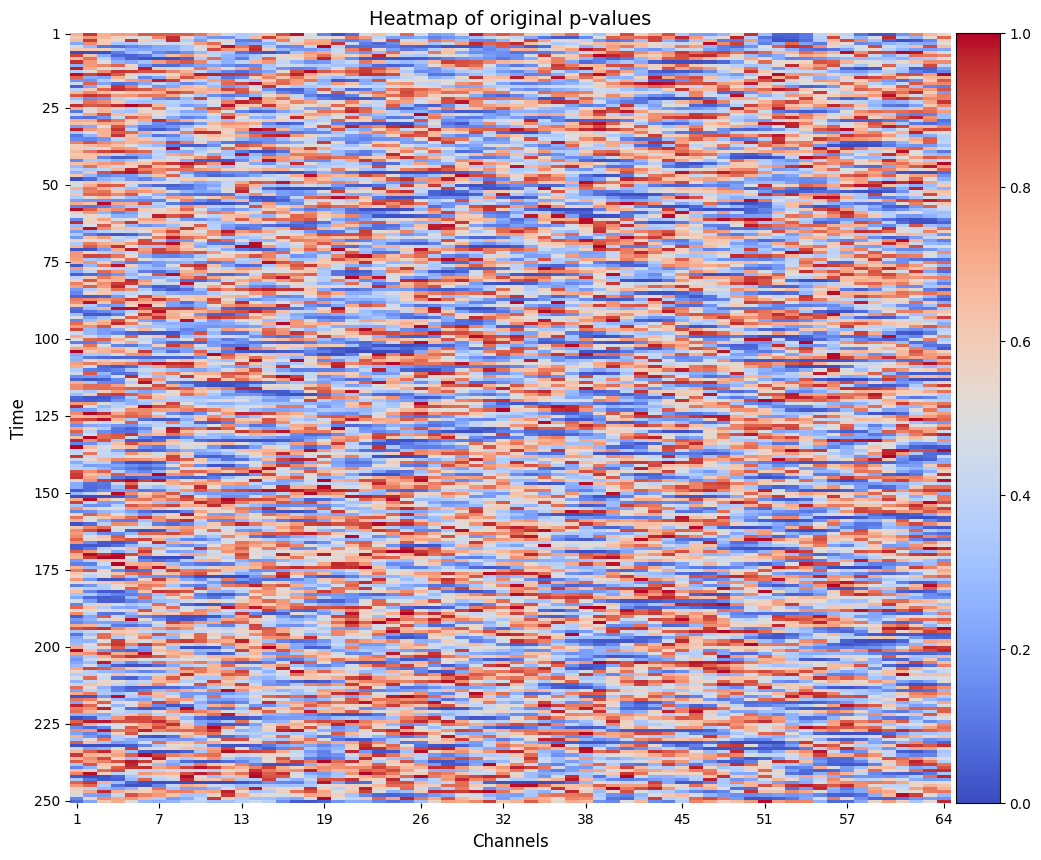

In [ ]:
from helperfunctions import plot_heatmap,plot_scatter_with_labels,plot_histograms
# Plot p-values
plot_heatmap(pval,method, title_text ="Heatmap of original p-values",annot=False, figsize=(12,10), xlabel="Channels")


**Vizualize p-values using scatter plots**

Visualizing which HMM states shows a significant different value using a scatter plot for each time point. In this case, we just look at the first 10 timepoints

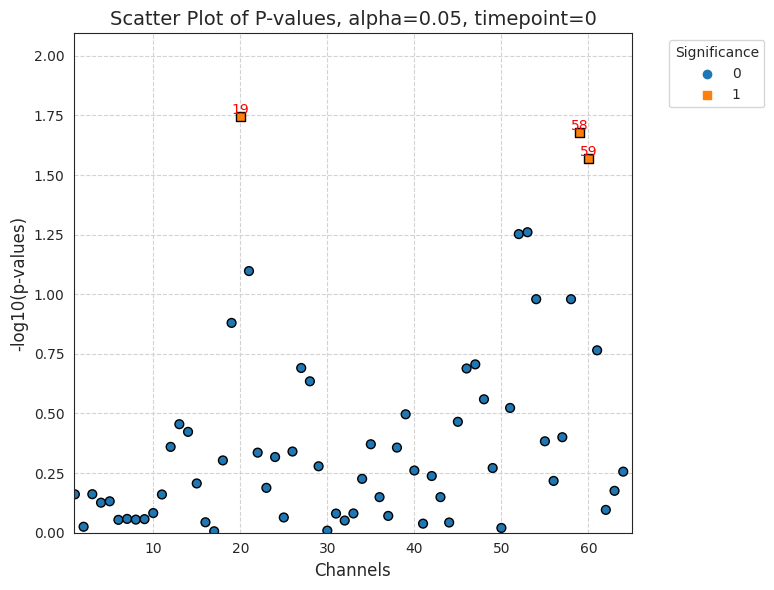

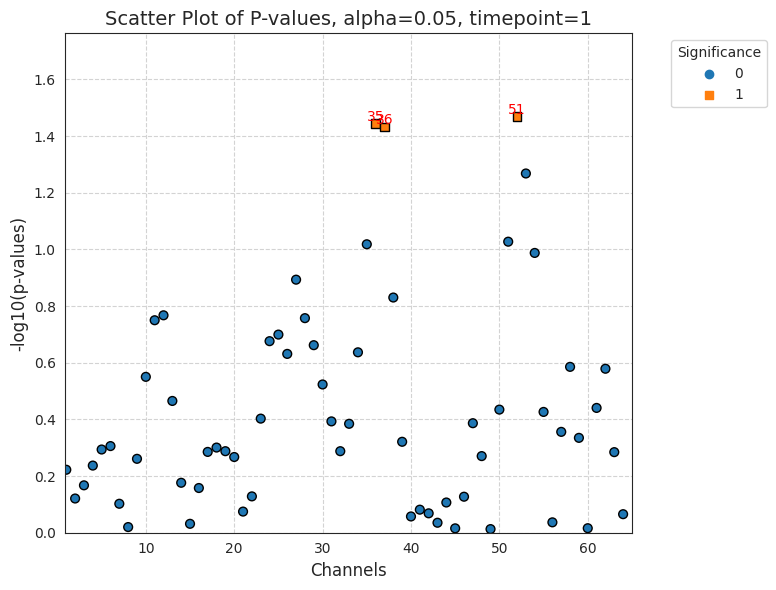

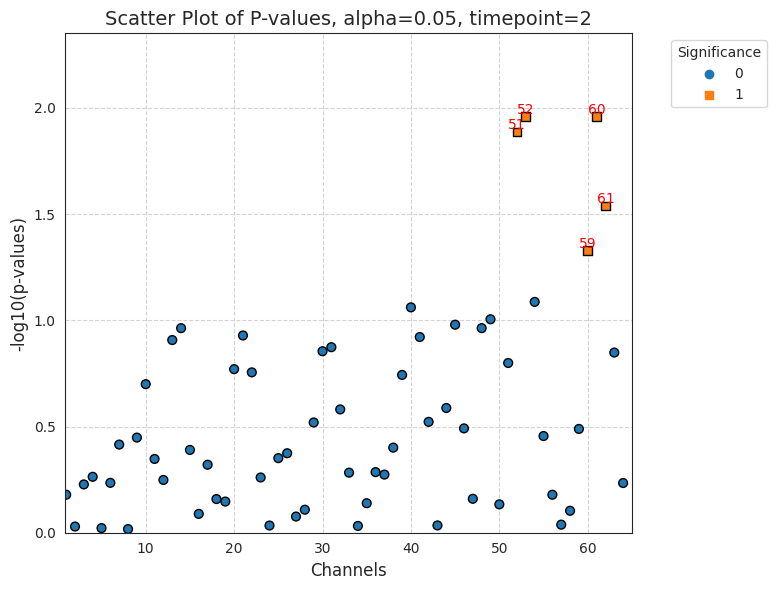

<ipython-input-23-4f3f28c8f0c2>:42: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(x=np.arange(0, len(p_values))+1, y=-np.log10(p_values), hue=hue, style=hue,


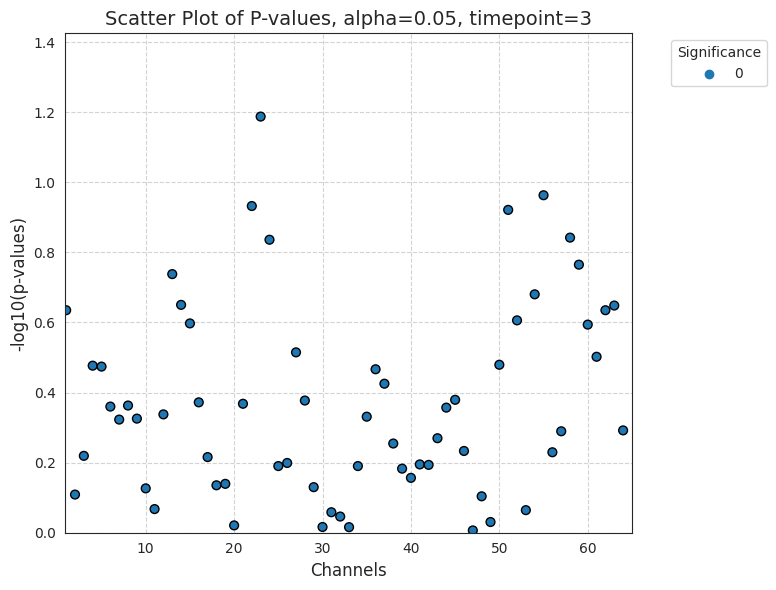

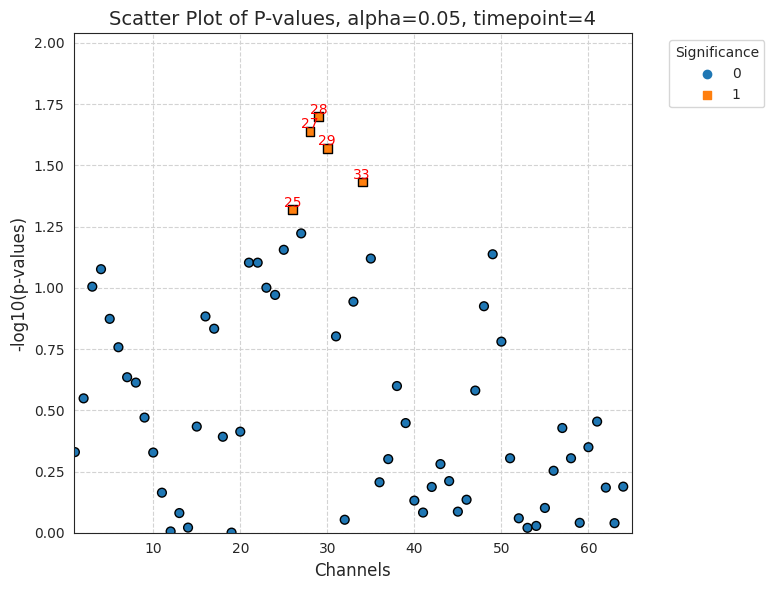

<ipython-input-23-4f3f28c8f0c2>:42: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(x=np.arange(0, len(p_values))+1, y=-np.log10(p_values), hue=hue, style=hue,


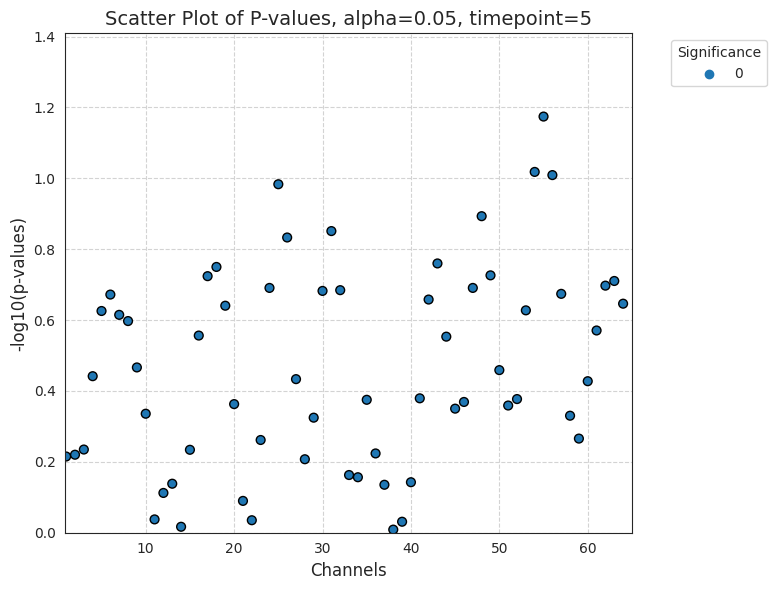

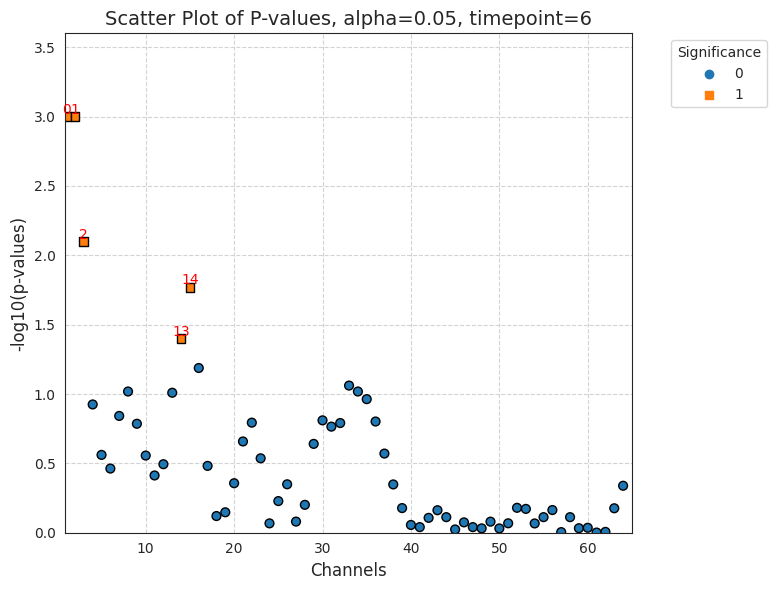

<ipython-input-23-4f3f28c8f0c2>:42: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(x=np.arange(0, len(p_values))+1, y=-np.log10(p_values), hue=hue, style=hue,


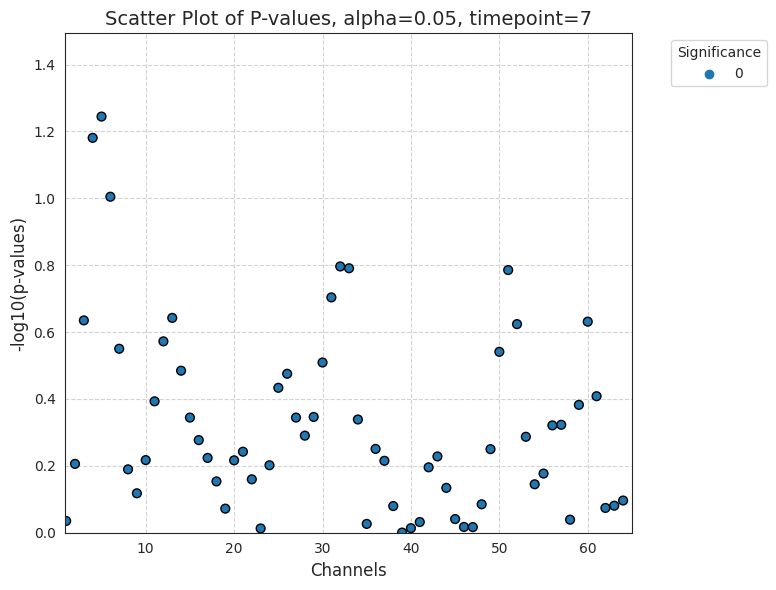

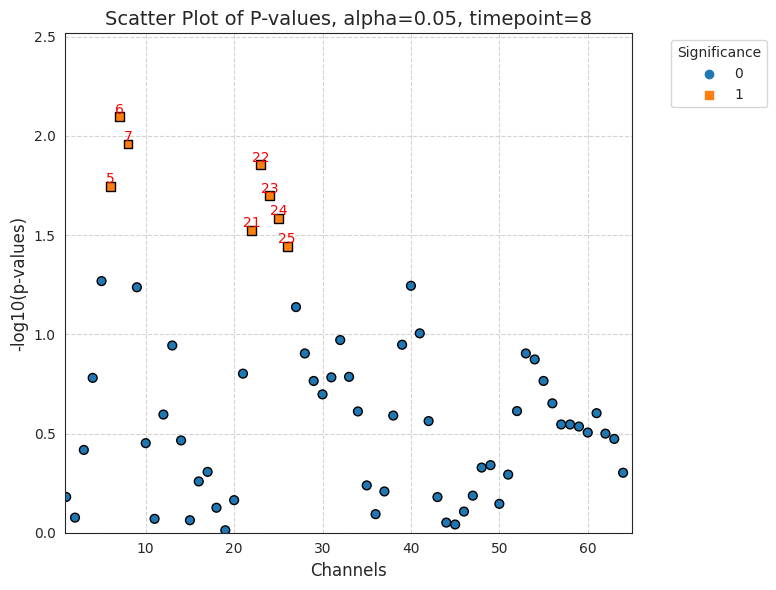

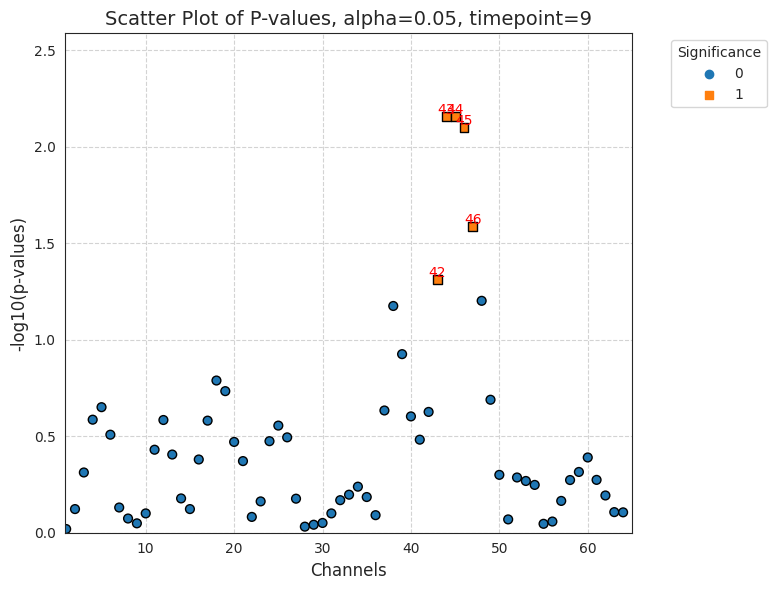

In [ ]:
#Scatter plot for the first 10 timepoints
alpha = 0.05
time_points=10
for i in range(time_points):
  title_text = f'Scatter Plot of P-values, alpha={alpha}, timepoint={i}'
  plot_scatter_with_labels(pval[i,:], alpha=0.05, title_text=title_text, xlabel="Channels")

**Plot the test staticstic of significant values**\
Here are the significant test statistics for the MEG scanner channels obtained using permutation and regression. The red line shows the observed statistic, while the datapoints of the histogram represent the estimated statistics of the permuted values.


In [ ]:
significant_timestamp_position, significant_indices = np.where(pval< alpha)

Plotting the test statistic for the channels that got a significant difference without correction at ```timepoint=0```

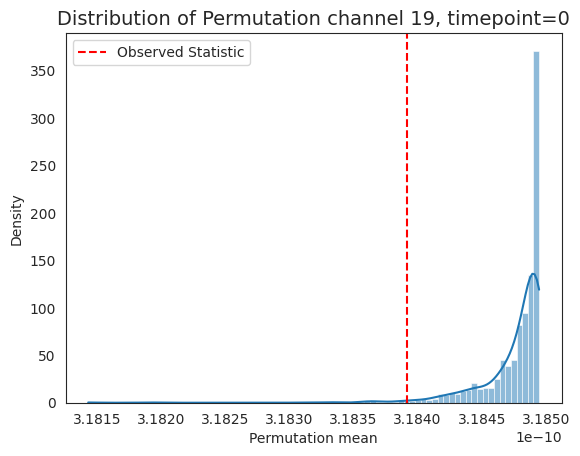

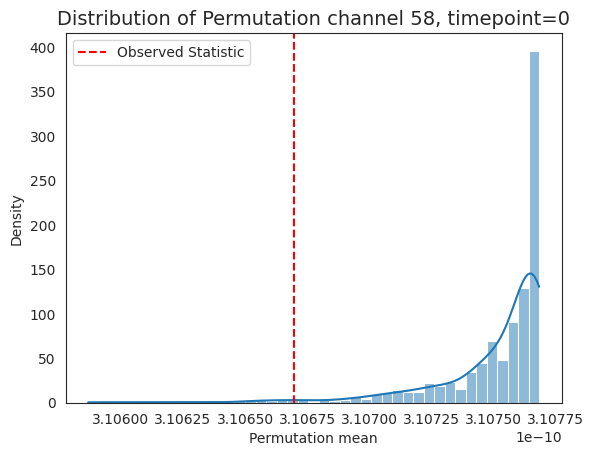

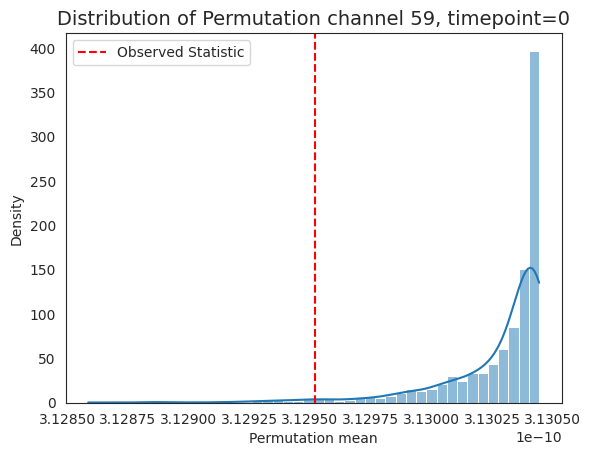

In [ ]:
# Plot test statistics for  pvals
alpha = 0.05
timepoint_position = 0 # Chosen timepoint
significant_timestamp_position, significant_indices = np.where(pval< alpha)
idx_time =significant_indices[np.where(significant_timestamp_position==timepoint_position)]


for i in idx_time:
    plot_histograms(test_statistic_list[timepoint_position,:,i],title_text=f"Distribution of Permutation channel {i}, timepoint={timepoint_position}")